# Exploring Text on Maps

In [1]:
# uncomment the following line to run if you have not yet installed geopandas
#!pip install -q geopandas==1.0.0a1

In [25]:
import pandas as pd
import geopandas as geopd
import matplotlib.pyplot as plt
import plotly.express as px
from ast import literal_eval
from collections import Counter
from tqdm import tqdm

In [2]:
def load_dataframe(file_path: str):
    # read file
    df = pd.read_csv(file_path, index_col=0)

    # eval columns
    for col in df.columns:
        try:
            df[col] = df[col].apply(literal_eval)
        except:
            pass

    # read polygon
    if "polygon" in df.columns:
        df["polygon"] = df["polygon"].apply(
            lambda x: x if isinstance(x, Polygon) else wkt.loads(x)
        )
    else:
        df["polygon"] = df["coordinates"].apply(
            lambda x: Polygon.from_bounds(*x)
        )

    # convert to geo dataframe
    df = geopd.GeoDataFrame(df, geometry="polygon", crs="EPSG:4326")

    return df

## 'Urban' vs 'Rural' text

In this notebook we will investigate the textual description of urban and rural landscape. We compare labels that often appear in the built environment versus the rest of the map. 

This notebooks has the following structure:
- for simplicity we convert all polygons to centroids
- we iterate over the dataframe with patch predictions
- we look which labels fall within a certain distance of the patch centoid
- depending on the patch prediction (building or not building) we save the labels in different lists (`adjacent_text` and `other_text`)
- we compute the probability of labels for each of these classes (`adjacent_text` and `other_text`) and compute the difference in proportions to foreground words that are associated with building patches ('urban' labels) and or not ('rural' labels).

In [16]:
# load patch predictions and spotted text
predictions = geopd.read_file("/path/to/building_patches.geojson")
spotted_text = geopd.read_file("/path/to/deepsolo_outputs.geojson")

In [22]:
# print the shapeof the dataframes
print(predictions.shape, spotted_text.shape)

(10470, 11) (649, 6)


In [23]:
# convert polygons to centroids
predictions['centroid'] = predictions['geometry'].to_crs(epsg=27700).centroid 
spotted_text['centroid'] = spotted_text['geometry'].to_crs(epsg=27700).centroid

In [39]:
tqdm.pandas()
adjacent_text = [] # here we store labels close to the target category, i.e. building clasified as 1
other_text = [] # here we store the other labels
target_label = 1
distance = 100 # maximum distance in meters between patch and text centroid

for i,row in tqdm(predictions.iterrows(), total=predictions.shape[0]):
    # get text within a certain distance from the patch centroid
    labels = spotted_text[spotted_text.to_crs(epsg=27700).distance(row.centroid) <= distance].text.tolist()
    # if patch is classified as the target label, add text to adjacent_text, otherwise add to other_text
    if row['pred'] == target_label:
        adjacent_text.extend(labels)
    else:   
        other_text.extend(labels)

print('Building labels',len(adjacent_text), 'Other labels',len(other_text))

  0%|          | 0/10470 [00:00<?, ?it/s]

100%|██████████| 10470/10470 [02:38<00:00, 65.91it/s]

1226 2360


In [40]:
# get counts and probabilities of the text labels for the building category
building_text_freq =  Counter([i.lower() for i in adjacent_text])
building_text_prob = {k: v/ sum(building_text_freq.values()) for k,v in building_text_freq.items()}

In [41]:
# get counts and probabilities of the text labels for the other category
other_text_freq =  Counter([i.lower() for i in other_text])
other_text_prob = {k: v/ sum(other_text_freq.values()) for k,v in other_text_freq.items()}

In [46]:
# compare both absoluate counts and probabilities of a give word
word = 'street'
print(building_text_freq[word], other_text_freq[word])
print(building_text_prob[word], other_text_prob[word])

18 9
0.01468189233278956 0.0038135593220338985


In [52]:
# compute the proportional difference
proportional_difference = sorted({w: building_text_prob.get(w,0) - other_text_prob.get(w,0) for w in other_text_prob.keys()}.items(), key=lambda x: x[1], reverse=True)


In [55]:
print('Building labels')
print(proportional_difference[:5])
print('Other labels')
print(proportional_difference[-5:])

Building labels
[('ph', 0.021111786988138356), ('church', 0.010868333010755661), ('street', 0.010868333010755661), ('lb', 0.01017986009345536), ('school', 0.010084469267564355)]
Other labels
[('old', -0.007976885005668151), ('colliery', -0.012510714186966018), ('bm', -0.013242043852130396), ('pit', -0.015021290126358281), ('sp', -0.01879268393839688)]


<Axes: title={'center': 'Top 10 terms in Building labels'}, xlabel='Term', ylabel='Difference in probability'>

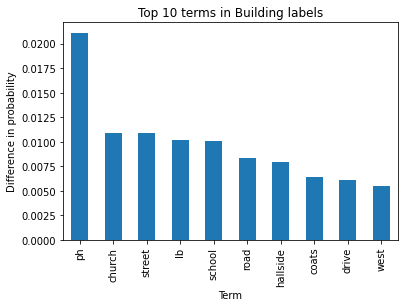

In [65]:
pd.DataFrame(proportional_difference[:10]).plot(kind='bar', x=0, y=1, legend=False, 
                            title='Top 10 terms in Building labels', 
                            xlabel='Term', ylabel='Difference in probability')

<Axes: title={'center': 'Top 10 terms in Other labels'}, xlabel='Term', ylabel='Difference in probability'>

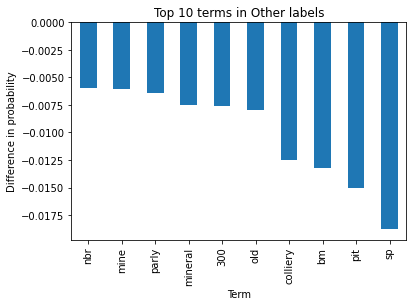

In [66]:
pd.DataFrame(proportional_difference[-10:]).plot(kind='bar', x=0, y=1, legend=False, 
                            title='Top 10 terms in Other labels', 
                            xlabel='Term', ylabel='Difference in probability')

To get a sense of what some of the abbreviations mean, please go to the NLS website: https://maps.nls.uk/os/abbrev/

# Visalizing the semantic of text on maps

In the visualization below we encode each label to a vector using BERT-type language model. This generates a vector for each labels that approximates the 'meaning' of this label. Then we visualize these embeddigns in two dimensional space where you can explore the different semantic regions of the text data.

In [67]:
# uncomment the following line to run if you have not yet installed sentence-transformers, scikit-learn and plotly
#!pip install -U -q sentence-transformers scikit-learn plotly

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
import plotly.express as px

In [70]:
# get all text labels
text_labels = spotted_text.text.str.lower().tolist()

In [71]:
# load pre-trained sentence transformer model
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

# encode the sentences
sentence_embeddings = model.encode(text_labels)



modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [72]:
# perform dimensionality reduction using TSNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(sentence_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [75]:
# visualize the labels in 2D scatter plot
data = pd.DataFrame(embeddings_tsne, columns=['x','y'])
data['text'] = text_labels
fig = px.scatter(data, x="x", y="y", text='text', width=1000, height=1000,)
fig.show()

In [79]:
# visualize only the text labels in 2D scatter plot
# i.e. remove all numbers
data_text = data[data.text.str.isalpha()]
fig = px.scatter(data_text, x="x", y="y", text='text', width=1000, height=1000,)
fig.show()

In [82]:
# visualize only the unique text labels in 2D scatter plot
# i.e. remove all numbers and duplicates
data_text_unique =data[data.text.str.isalpha()].drop_duplicates(subset='text')
fig = px.scatter(data_text_unique, x="x", y="y", text='text', width=1000, height=1000,)
fig.show()